In [1]:
import numpy as np
import torch
from typing import Callable, Dict, Optional, Tuple
import math
from tqdm import trange
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
# utilities
def _gaussian_kernel(a: torch.Tensor, b: torch.Tensor, bw: float) -> torch.Tensor:
    # RBF kernel k(x,y) = exp(-||x-y||^2 / bw)
    # a: (N, d), b: (M, d) -> (N, M)
    return torch.exp(-torch.cdist(a, b) ** 2 / bw)

def _simulate_gaussian_mean(theta: torch.Tensor, eps_y: torch.Tensor, sigma_x2: float = 1.0) -> torch.Tensor:
    # Gaussian location model samples:
    # theta: (M, d)
    # eps_y: (M, S, d) ~ N(0, I)
    # returns Y: (M, S, d) with Y = theta[:,None,:] + sqrt(sigma_x2) * eps_y
    return theta[:, None, :] + (sigma_x2 ** 0.5) * eps_y

def _E_mmd2(
    X: torch.Tensor,
    Y: torch.Tensor,
    kernel_fn: Callable,
    bw: float,
    M: int,
    S: int,
) -> torch.Tensor:
    # Existing-method MMD^2 (biased estimator for training stability):
    #   (1/M) * sum_i MMD^2(P_{θ_i},  P̂_n)
    # Inputs:
    #   X: (n, d) data
    #   Y: (M*S, d) pooled samples
    n, d = X.shape
    Kxx = kernel_fn(X, X, bw).mean()
    Kxy = kernel_fn(X, Y, bw).view(n, M, S).mean(dim=(0, 2))  # per-particle
    Kyy_blocks = kernel_fn(Y, Y, bw).view(M, S, M, S)
    Kyy_diag = Kyy_blocks.diagonal(dim1=0, dim2=2).permute(2, 0, 1)  # (M, S, S)
    Kyy = Kyy_diag.mean(dim=(1, 2))  # per-particle mean
    mmd2_per_particle = Kxx - 2.0 * Kxy + Kyy
    return mmd2_per_particle.mean()

def _mix_mmd2(
    X: torch.Tensor,
    Y: torch.Tensor,
    kernel_fn: Callable,
    bw: float,
) -> torch.Tensor:
    # Mixture MMD^2:
    Kxx = kernel_fn(X, X, bw).mean()
    Kxy = kernel_fn(X, Y, bw).mean()
    Kyy = kernel_fn(Y, Y, bw).mean()
    return Kxx - 2.0 * Kxy + Kyy

def _var_emb(
    Y: torch.Tensor,
    kernel_fn: Callable,
    bw: float,
    M: int,
    S: int,
) -> torch.Tensor:
    # RKHS embedding variance term (equals E_θ MMD^2(P_θ, mix)):
    K = kernel_fn(Y, Y, bw)                       # (M*S, M*S)
    pooled = K.mean()                              # E_mix[k]
    K_blocks = K.view(M, S, M, S)
    within = K_blocks.diagonal(dim1=0, dim2=2).mean()  # E_θ E_{Y,Y'~P_θ}[k]
    return within - pooled

In [ ]:
# Existing MMD-Bayes VI
def vi_mmd(
    X: torch.Tensor,
    beta: float,
    steps: int = 1000,
    beta_schedule: Callable = lambda t, T, beta: beta * min(1.0, (t + 1) / max(1.0, 0.1 * T)),
    lr: float = 5e-3,
    M: int = 32,
    S: int = 32,
    kernel_fn: Callable = _gaussian_kernel,
    simulate_fn: Callable = _simulate_gaussian_mean,
    sigma_x2: float = 1.0,
    prior_tau2: float = 1.0,
    lambda_kl: float = 0.005,
    device: Optional[str] = None,
    dtype: torch.dtype = torch.float64,
    return_particles: bool = True,
):
    # Optimize (existing objective) via MFLD
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    X = X.to(device, dtype=dtype)
    n, d = X.shape

    with torch.no_grad():
        idx = torch.randperm(n, device=device)[:min(1000, n)]
        pair = torch.pdist(X[idx])
        bw = pair.median().pow(2).item() if pair.numel() > 0 else float(d)
        if bw < 1e-12:
            bw = float(d)

    theta = (prior_tau2 ** 0.5) * torch.randn(M, d, device=device, dtype=dtype)
    theta.requires_grad_(True)

    for t in range(1, steps + 1):
        beta_t = beta_schedule(t, steps, beta)
        eps = torch.randn(M, S, d, device=device, dtype=dtype)
        Y = simulate_fn(theta, eps_y=eps, sigma_x2=sigma_x2)
        Y = Y.reshape(M * S, d)

        mmd_term = _E_mmd2(X, Y, kernel_fn, bw, M, S)
        # KL term approx: E_μ[-log π] (entropy from noise)
        prior_term = (lambda_kl / (2.0 * prior_tau2)) * theta.pow(2).sum() / M
        U = beta_t * mmd_term + prior_term

        grads = torch.autograd.grad(U, theta, create_graph=False)[0]
        with torch.no_grad():
            noise = torch.randn_like(theta) * math.sqrt(2.0 * lambda_kl * lr)
            theta.add_(-lr * grads + noise)
        theta.requires_grad_(True)

    m_hat = theta.detach().mean(dim=0).cpu().numpy()
    sigma2_hat = theta.detach().var(dim=0, unbiased=False).cpu().numpy()
    return (m_hat, sigma2_hat, theta.detach() if return_particles else None)

In [ ]:
# Mixture MMD-Bayes VI
def vi_mix_mmd(
    X: torch.Tensor,
    beta: float,
    alpha: float = 0.2,
    steps: int = 1000,
    beta_schedule: Callable = lambda t, T, beta: beta * min(1.0, (t + 1) / max(1.0, 0.1 * T)),
    lr: float = 5e-3,
    M: int = 32,
    S: int = 32,
    kernel_fn: Callable = _gaussian_kernel,
    simulate_fn: Callable = _simulate_gaussian_mean,
    sigma_x2: float = 1.0,
    prior_tau2: float = 1.0,
    lambda_kl: float = 0.005,
    device: Optional[str] = None,
    dtype: torch.dtype = torch.float64,
    return_particles: bool = True,
):
    # Proposed objective via MFLD
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    X = X.to(device, dtype=dtype)
    n, d = X.shape

    with torch.no_grad():
        idx = torch.randperm(n, device=device)[:min(1000, n)]
        pair = torch.pdist(X[idx])
        bw = pair.median().pow(2).item() if pair.numel() > 0 else float(d)
        if bw < 1e-12:
            bw = float(d)

    theta = (prior_tau2 ** 0.5) * torch.randn(M, d, device=device, dtype=dtype)
    theta.requires_grad_(True)

    for t in range(1, steps + 1):
        beta_t = beta_schedule(t, steps, beta)
        eps = torch.randn(M, S, d, device=device, dtype=dtype)
        Y = simulate_fn(theta, eps_y=eps, sigma_x2=sigma_x2)
        Y = Y.reshape(M * S, d)

        mmd_term = _mix_mmd2(X, Y, kernel_fn, bw)
        var_term = _var_emb(Y, kernel_fn, bw, M, S)
        prior_term = (lambda_kl / (2.0 * prior_tau2)) * theta.pow(2).sum() / M
        U = beta_t * mmd_term + alpha * var_term + prior_term

        grads = torch.autograd.grad(U, theta, create_graph=False)[0]
        with torch.no_grad():
            noise = torch.randn_like(theta) * math.sqrt(2.0 * lambda_kl * lr)
            theta.add_(-lr * grads + noise)
        theta.requires_grad_(True)

    m_hat = theta.detach().mean(dim=0).cpu().numpy()
    sigma2_hat = theta.detach().var(dim=0, unbiased=False).cpu().numpy()
    return (m_hat, sigma2_hat, theta.detach() if return_particles else None)

In [5]:
# Energy distance (unbiased)
def ed2_unbiased(X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
    # Unbiased U-statistic estimator of Energy Distance^2 between two samples.
    # X: (n, d), Y: (m, d)
    n, m = X.shape[0], Y.shape[0]
    if n < 2 or m < 2:
        # fallback: biased
        xy = torch.cdist(X, Y).mean() * 2.0
        xx = torch.cdist(X, X).mean()
        yy = torch.cdist(Y, Y).mean()
        return xy - xx - yy

    xy = torch.cdist(X, Y).mean() * 2.0
    xx_full = torch.cdist(X, X)
    yy_full = torch.cdist(Y, Y)
    xx = (xx_full.sum() - torch.diagonal(xx_full, 0).sum()) / (n * (n - 1))
    yy = (yy_full.sum() - torch.diagonal(yy_full, 0).sum()) / (m * (m - 1))
    return xy - xx - yy

In [7]:
# Mixture Gaussian data generation
def make_mixture_means(d: int, K: int, separation: float = 3.0, sigma: float = 1.0) -> np.ndarray:
    # Construct K mean vectors m_k in R^d with approx given separation (units of sigma).
    if d == 1:
        centers = (np.arange(K) - (K - 1 ) / 2.0) * separation * sigma
        return centers.reshape(K, 1)
    if d >= K:
        means = np.zeros((K, d), dtype=float)
        for k in range(K):
            means[k, k] = ((-1)**k) * separation * sigma
        return means
    # d < K: place on a circle in the first two dims
    angles = np.linspace(0, 2 * np.pi, K, endpoint=False)
    means = np.zeros((K, d), dtype=float)
    radius = separation * sigma
    means[:, 0] = radius * np.cos(angles)
    if d >= 2:
        means[:, 1] = radius * np.sin(angles)
    return means

def sample_mixture_gaussian(
    n: int,
    d: int,
    K: int,
    sigma: float = 1.0,
    separation: float = 3.0,
    weights: Optional[np.ndarray] = None,
    means: Optional[np.ndarray] = None,
    rng: Optional[np.random.Generator] = None,
) -> np.ndarray:
    # Sample n points from a Gaussian mixture with K components in R^d.
    rng = rng or np.random.default_rng()
    if means is None:
        means = make_mixture_means(d, K, separation=separation, sigma=sigma)
    else:
        means = np.asarray(means, dtype=float).reshape(K, d)
    if weights is None:
        weights = np.ones(K, dtype=float) / K
    else:
        weights = np.asarray(weights, dtype=float)
        weights = weights / weights.sum()
    z = rng.choice(K, size=n, p=weights)
    X = rng.normal(loc=means[z], scale=sigma, size=(n, d))
    return X

In [8]:
# Prediction sampling from each model
def sample_predictive_mle(theta_hat: np.ndarray, m: int, sigma: float, device: Optional[str] = None, dtype=torch.float64) -> torch.Tensor:
    d = theta_hat.shape[0]
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    eps = torch.randn(m, d, device=device, dtype=dtype)
    theta = torch.as_tensor(theta_hat, device=device, dtype=dtype)
    return theta[None, :] + sigma * eps

def sample_predictive_med(theta_hat: np.ndarray, m: int, sigma: float, device: Optional[str] = None, dtype=torch.float64) -> torch.Tensor:
    return sample_predictive_mle(theta_hat, m, sigma, device=device, dtype=dtype)

def sample_predictive_particles(theta: torch.Tensor, m: int, sigma: float, device: Optional[str] = None, dtype=torch.float64) -> torch.Tensor:
    # Predictive sampling from particle mixture: choose particle uniformly
    device = device or theta.device
    M, d = theta.shape
    idx = torch.randint(low=0, high=M, size=(m,), device=device)
    eps = torch.randn(m, d, device=device, dtype=dtype)
    return theta[idx, :] + sigma * eps

In [ ]:
def run(
    dim: int = 1,
    K: int = 2,
    separation: float = 3.0,
    weights: Optional[np.ndarray] = None,
    sigma: float = 1.0,
    n_train: int = 1000,
    n_test: int = 2000,
    steps: int = 800,
    M: int = 64,
    S: int = 32,
    beta: Optional[float] = None,
    alpha: float = 0.2,
    prior_tau2: float = 4.0,
    lambda_kl: float = 0.005,
    med_steps: int = 300,
    med_lr: float = 5e-2,
    med_msamples: int = 2048,
    R: int = 100,
    seed: Optional[int] = None,
    device: Optional[str] = None,
    dtype: torch.dtype = torch.float64,
) -> Dict[str, float]:
    # Run the mixture Gaussian distribution-fit experiment with ED^2 as the only metric.
    if seed is not None:
        base_rng = np.random.default_rng(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)
    else:
        base_rng = np.random.default_rng()

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    if beta is None:
        beta = float(n_train * dim)

    # results = {"MLE": [], "MED": [], "MMD": [], "Mixture-MMD": []}
    results = {"MMD": [], "Mixture-MMD": []}

    for r in trange(R, leave=False):
        rng = np.random.default_rng(base_rng.integers(0, 1<<31))

        # sample train/test
        X_train_np = sample_mixture_gaussian(n=n_train, d=dim, K=K, sigma=sigma, separation=separation, weights=weights, rng=rng)
        X_test_np  = sample_mixture_gaussian(n=n_test,  d=dim, K=K, sigma=sigma, separation=separation, weights=weights, rng=rng)
        X_train = torch.from_numpy(X_train_np).to(device=device, dtype=dtype)
        X_test  = torch.from_numpy(X_test_np ).to(device=device, dtype=dtype)

        # MMD-Bayes VI
        m_hat, s2_hat, theta_particles = vi_mmd(
            X_train, 
            beta=beta, 
            steps=steps, 
            lr=5e-3, 
            M=M, 
            S=S,
            sigma_x2=sigma**2, 
            prior_tau2=prior_tau2, 
            lambda_kl=lambda_kl,
            device=device, 
            dtype=dtype, 
            return_particles=True,
        )
        Y_mmd = sample_predictive_particles(theta_particles, m=n_test, sigma=sigma, device=device, dtype=dtype)
        ed2_mmd = ed2_unbiased(X_test, Y_mmd).item()
        results["MMD"].append(ed2_mmd)

        # Mixture MMD-Bayes VI
        m_hat2, s2_hat2, theta_particles2 = vi_mix_mmd(
            X_train, 
            beta=beta, 
            alpha=alpha, 
            steps=steps, 
            lr=5e-3, 
            M=M, 
            S=S,
            sigma_x2=sigma**2, 
            prior_tau2=prior_tau2, 
            lambda_kl=lambda_kl,
            device=device, 
            dtype=dtype, 
            return_particles=True,
        )
        Y_mix = sample_predictive_particles(theta_particles2, m=n_test, sigma=sigma, device=device, dtype=dtype)
        ed2_mix = ed2_unbiased(X_test, Y_mix).item()
        results["Mixture-MMD"].append(ed2_mix)

    # aggregate
    out = {}
    for k, vals in results.items():
        arr = np.array(vals, dtype=float)
        mean = float(arr.mean())
        se   = float(arr.std(ddof=1) / max(1, np.sqrt(len(arr))))
        out[k] = {"mean_ED2": mean, "stderr": se, "runs": int(len(arr))}
    return out

In [ ]:
res_1_2 = run(
    dim=1, 
    K=2, 
    separation=3.0, 
    sigma=1.0,
    n_train=1000, 
    n_test=2000, 
    steps=1200,
    M=32, 
    S=32, 
    R=100, 
    seed=None,
)
res_1_2

{'MMD': {'mean_ED2': 0.2238503655107531,
  'stderr': 0.0014772071914450056,
  'runs': 100},
 'Mixture-MMD': {'mean_ED2': 0.003733246528748957,
  'stderr': 0.000544284447018521,
  'runs': 100}}

In [20]:
res_1_4 = run(
    dim=1,
    K=4,
    separation=3.0,
    sigma=1.0,
    n_train=1000,
    n_test=2000,
    steps=1200,
    M=32,
    S=32,
    R=100,
    seed=None,
)
res_1_4

{'MMD': {'mean_ED2': 1.0692716407190643,
  'stderr': 0.006122637204438674,
  'runs': 100},
 'Mixture-MMD': {'mean_ED2': 0.005629805587669536,
  'stderr': 0.0006261515375278398,
  'runs': 100}}

In [21]:
res_15_2 = run(
    dim=15,
    K=2,
    separation=3.0,
    sigma=1.0,
    n_train=2000,
    n_test=5000,
    steps=2000,
    M=64,
    S=64,
    R=100,
    seed=None,
)
res_15_2

{'MMD': {'mean_ED2': 0.06338079814335768,
  'stderr': 0.0002866823864587097,
  'runs': 100},
 'Mixture-MMD': {'mean_ED2': 0.0028555580657342004,
  'stderr': 0.00021999802335407565,
  'runs': 100}}

In [22]:
res_15_4 = run(
    dim=15,
    K=4,
    separation=3.0,
    sigma=1.0,
    n_train=2000,
    n_test=5000,
    steps=2000,
    M=64,
    S=64,
    R=100,
    seed=None,
)
res_15_4

{'MMD': {'mean_ED2': 0.07653573212952282,
  'stderr': 0.00025888411220196503,
  'runs': 100},
 'Mixture-MMD': {'mean_ED2': 0.002700164707266719,
  'stderr': 0.0001413409313680464,
  'runs': 100}}

In [ ]:
def sample_predictive_point(theta_hat, m, sigma, dtype=torch.float32, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    return torch.as_tensor(theta_hat, device=device, dtype=dtype)[None, :] + sigma * torch.randn(m, theta_hat.shape[0], device=device, dtype=dtype)

def sample_predictive_particles(theta, m, sigma, dtype=torch.float32, device=None):
    device = device or theta.device
    M, d = theta.shape
    idx = torch.randint(0, M, (m,), device=device)
    return theta[idx, :] + sigma * torch.randn(m, d, device=device, dtype=dtype)

def make_means(d, K, separation=3.0, sigma=1.0):
    if d == 1:
        centers = (np.arange(K) - (K - 1) / 2) * separation * sigma
        return centers.reshape(K, 1)
    means = np.zeros((K,d))
    if d >= K:
        for k in range(K): 
            means[k, k] = ((-1) ** k) * separation * sigma
    else:
        ang = np.linspace(0,2 * np.pi, K, endpoint=False)
        means[:, 0] = separation * sigma * np.cos(ang)
        if d >= 2: 
            means[:, 1] = separation * sigma * np.sin(ang)
    return means

def sample_mog(n, d, K, sigma=1.0, separation=3.0, weights=None, rng=None):
    rng = rng or np.random.default_rng()
    means = make_means(d, K, separation, sigma)
    w = (np.ones(K) / K) if weights is None else np.asarray(weights) / np.sum(weights)
    z = rng.choice(K, size=n, p=w)
    X = rng.normal(loc=means[z], scale=sigma, size=(n,d))
    return X, means, w

In [14]:
def plot_1d(dim=1, K=2, separation=3.0, sigma=1.0, n_train=800, n_test=2000, steps=1200, M=32, S=32, alpha=0.2, seed=0):
    rng = np.random.default_rng(seed)
    Xtr_np, _, _ = sample_mog(n_train, dim, K, sigma, separation, rng=rng)
    Xte_np, _, _ = sample_mog(n_test,  dim, K, sigma, separation, rng=rng)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype=torch.float32
    Xtr = torch.from_numpy(Xtr_np).to(device=device, dtype=dtype)
    Xte = torch.from_numpy(Xte_np).to(device=device, dtype=dtype)

    beta = float(n_train * dim)
    alpha = 0.25 * beta
    m_hat, s2_hat, theta_mmd = vi_mmd(Xtr, beta=beta, steps=steps, lr=5e-3, M=M, S=S, sigma_x2=sigma**2, dtype=dtype, device=device)
    m_hat2, s2_hat2, theta_mix = vi_mix_mmd(Xtr, beta=beta, alpha=alpha, steps=steps, lr=5e-3, M=M, S=S, sigma_x2=sigma**2, dtype=dtype, device=device)

    m = n_test
    Y_mmd = sample_predictive_particles(theta_mmd, m, sigma, dtype=dtype, device=device).cpu().numpy().ravel()
    Y_mix = sample_predictive_particles(theta_mix, m, sigma, dtype=dtype, device=device).cpu().numpy().ravel()
    
    Xte = Xte.cpu().numpy().ravel()

    def ed2_np(a,b): 
        return float(ed2_unbiased(torch.tensor(a)[:, None].float(), torch.tensor(b)[:, None].float()))
    eds = {
        "MMD-Bayes VI": ed2_np(Xte, Y_mmd),
        "Mixture MMD-Bayes VI": ed2_np(Xte, Y_mix),
    }

    for name, Y in [("MMD-Bayes VI", Y_mmd), ("Mixture MMD-Bayes VI", Y_mix)]:
        plt.figure()
        plt.hist(Xte, bins=60, density=True, alpha=0.4, label="True (test)")
        plt.hist(Y,   bins=60, density=True, alpha=0.4, label=f"{name} (ED²={eds[name]:.3f})")
        plt.title(f"1D mixture fit: {name} vs True")
        plt.xlabel("x"); plt.ylabel("density"); plt.legend()
        plt.show()


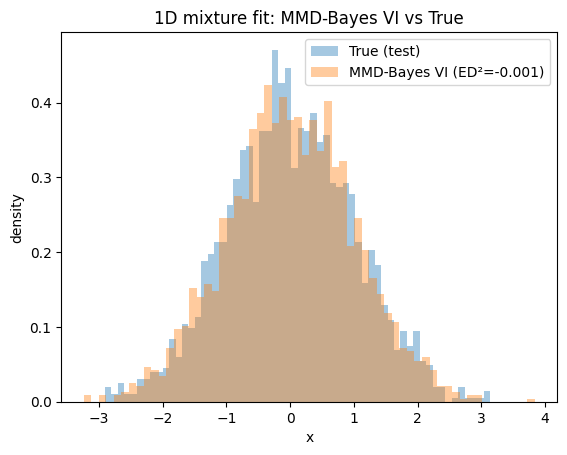

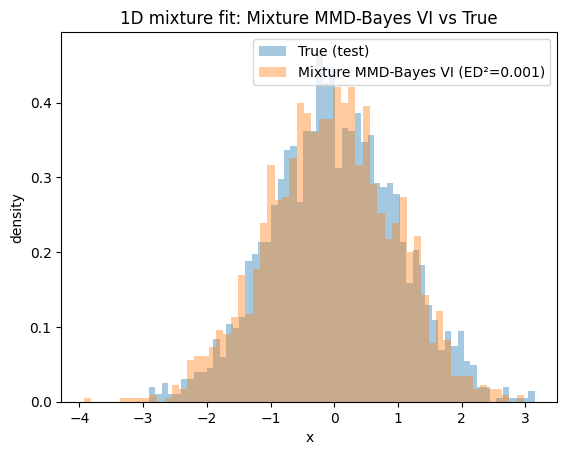

In [15]:
plot_1d(dim=1, K=1, separation=3.0, sigma=1.0, n_train=1000, n_test=2000, steps=1500, M=32, S=32, alpha=0.2, seed=0)

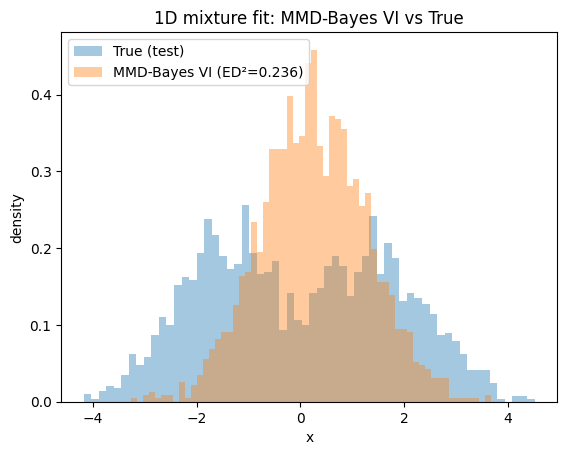

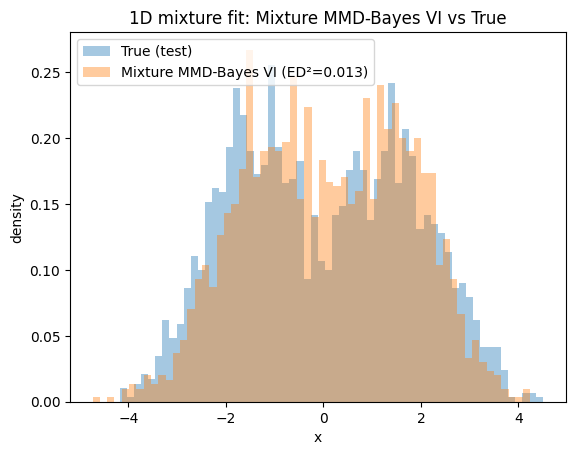

In [16]:
plot_1d(dim=1, K=2, separation=3.0, sigma=1.0, n_train=1000, n_test=2000, steps=1500, M=32, S=32, alpha=0.2, seed=0)

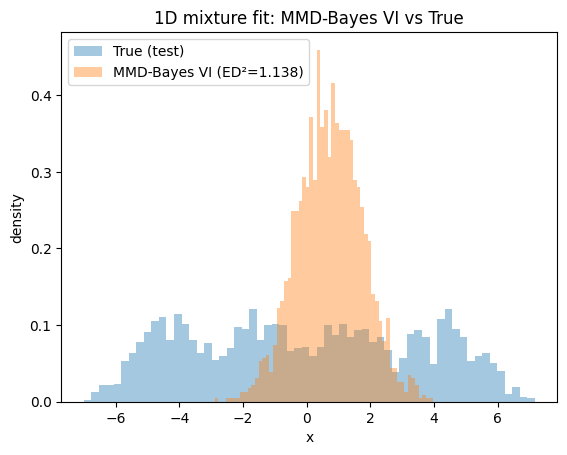

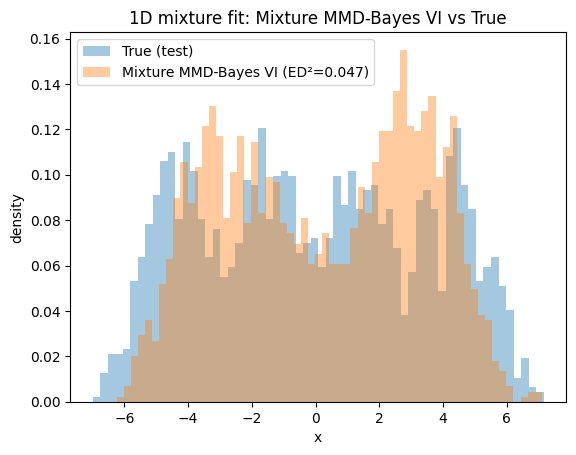

In [17]:
plot_1d(dim=1, K=4, separation=3.0, sigma=1.0, n_train=1000, n_test=2000, steps=1500, M=32, S=32, alpha=0.2, seed=0)

In [18]:
def plot_15d(K=4, separation=3.0, sigma=1.0, n_train=2000, n_test=4000, steps=1200, M=64, S=16, alpha=0.2, seed=1):
    rng = np.random.default_rng(seed)
    d=15
    Xtr_np, _, _ = sample_mog(n_train, d, K, sigma, separation, rng=rng)
    Xte_np, _, _ = sample_mog(n_test,  d, K, sigma, separation, rng=rng)

    device="cpu"; dtype=torch.float32
    Xtr = torch.from_numpy(Xtr_np).to(device=device, dtype=dtype)
    Xte = torch.from_numpy(Xte_np).to(device=device, dtype=dtype)

    
    beta = float(n_train * d)
    m_hat, s2_hat, theta_mmd = vi_mmd(Xtr, beta=beta, steps=steps, lr=5e-3, M=M, S=S, sigma_x2=sigma**2, dtype=dtype, device=device)
    m_hat2, s2_hat2, theta_mix = vi_mix_mmd(Xtr, beta=beta, alpha=alpha, steps=steps, lr=5e-3, M=M, S=S, sigma_x2=sigma**2, dtype=dtype, device=device)

    m = n_test
    Y_mmd = sample_predictive_particles(theta_mmd, m, sigma, dtype=dtype, device=device).cpu().numpy()
    Y_mix = sample_predictive_particles(theta_mix, m, sigma, dtype=dtype, device=device).cpu().numpy()
    Xte = Xte.cpu().numpy()

    Xc = Xte - Xte.mean(0, keepdims=True)
    U,S,Vt = np.linalg.svd(Xc, full_matrices=False)
    W = Vt[:2].T
    P_true = Xc @ W
    P = {
        "MMD-Bayes VI": (Y_mmd - Xte.mean(0)) @ W,
        "Mixture-MMD-Bayes VI": (Y_mix - Xte.mean(0)) @ W,
    }

    def ed2_np(A,B): 
        return float(ed2_unbiased(torch.tensor(A).float(), torch.tensor(B).float()))
    eds = {
        "MMD-Bayes VI": ed2_np(Xte, Y_mmd),
        "Mixture-MMD-Bayes VI": ed2_np(Xte, Y_mix),
    }

    for name in ["MMD-Bayes VI","Mixture-MMD-Bayes VI"]:
        plt.figure()
        plt.scatter(P_true[:,0], P_true[:,1], s=6, alpha=0.3, label="True (test)")
        plt.scatter(P[name][:,0], P[name][:,1], s=6, alpha=0.3, label=f"{name} (ED²={eds[name]:.2f})")
        plt.title(f"15D mixture: PCA(2D) — True vs {name}")
        plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
        plt.show()

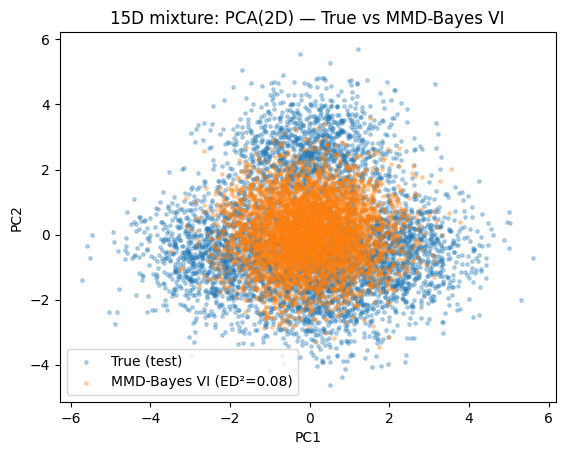

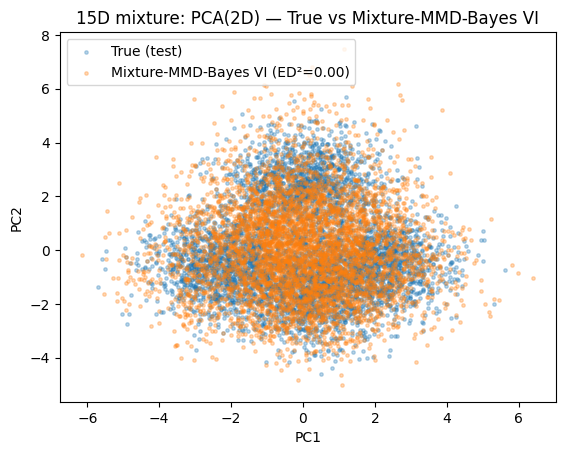

In [19]:
plot_15d(K=4, separation=3.0, sigma=1.0, n_train=2000, n_test=5000, steps=1200, M=64, S=64, alpha=0.2, seed=1)